https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

In [1]:
#Use depthwise separable convolutions, linear bottlenecks, and inverted residuals to build a MobileNetV2 model for image classification on the dataset using Pytorch.

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, device
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader
import numpy as np

from torch.utils.tensorboard import SummaryWriter

Setting up tensorboard

In [3]:
writer = SummaryWriter('runs/mobilenet_experiment_1')

Loading my images into a dataframe to make data processing easier

In [4]:
train_dataframe = pd.DataFrame(
    {
        'image_name': [],
        'class': [],
    }
).set_index('image_name', verify_integrity=True) #No duplicate image names allowed

test_dataframe = pd.DataFrame(
    {
        'image_name': [],
        'class': [],
    }
).set_index('image_name', verify_integrity=True)

In [5]:
for files in os.listdir('data/Training'):
    if files.startswith('.'):
        continue
    img_in_current_dir = os.listdir('data/Training/' + files)
    total_images = len(img_in_current_dir)
    if files.startswith('.'):
        continue
    for image in img_in_current_dir:
        img = plt.imread(os.path.join('data/Training', files, image))
        train_dataframe.loc[image] = {
            'class': files,
        }

In [6]:
for files in os.listdir('data/Testing'):
    if files.startswith('.'):
        continue
    img_in_current_dir = os.listdir('data/Testing/' + files)
    total_images = len(img_in_current_dir)
    if files.startswith('.'):
        continue
    for image in img_in_current_dir:
        img = plt.imread(os.path.join('data/Testing', files, image))
        test_dataframe.loc[image] = {
            'class': files,
        }

In [7]:
train_dataframe.sample(10)

,class
image_name,
p (807).jpg,pituitary_tumor
m (48).jpg,meningioma_tumor
gg (238).jpg,glioma_tumor
m2 (14).jpg,meningioma_tumor
gg (697).jpg,glioma_tumor
m1(49).jpg,meningioma_tumor
m (119).jpg,meningioma_tumor
p (417).jpg,pituitary_tumor
gg (788).jpg,glioma_tumor


In [8]:
test_dataframe.sample(10)

,class
image_name,
image(44).jpg,pituitary_tumor
image(51).jpg,pituitary_tumor
image(39).jpg,glioma_tumor
image(35).jpg,pituitary_tumor
image(46).jpg,pituitary_tumor
image(102).jpg,meningioma_tumor
image(89).jpg,pituitary_tumor
image(18).jpg,pituitary_tumor
image(24).jpg,glioma_tumor


one hot encoding the classes

In [9]:
train_dataframe = pd.get_dummies(train_dataframe,columns=['class'], dtype='long')
test_dataframe = pd.get_dummies(test_dataframe,columns=['class'], dtype='long')
train_dataframe

,class_glioma_tumor,class_meningioma_tumor,class_no_tumor,class_pituitary_tumor
image_name,,,,
image(115).jpg,0,0,1,0
image(142).jpg,0,0,1,0
image(49).jpg,0,0,1,0
image(1).jpg,0,0,1,0
image(284).jpg,0,0,1,0
...,...,...,...,...
p (663).jpg,0,0,0,1
p (399).jpg,0,0,0,1
p (233).jpg,0,0,0,1


In [10]:
from torchvision.io import decode_image
from torchvision.io import ImageReadMode
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, root_dir, transform=None):
        self.dataset: pd.DataFrame = dataset
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, idx):
        row = self.dataset.iloc[idx] #Get the row at the int index, all columns
        #Label is whichever column has a 1 in it (the class)

        #Get the index of the column with a 1 in it (the class), 0 because this returns a series with one value
        label_for_index = row[row == 1].index[0].split("_", 1)[1] #Get class name (one hot encoded column name) after the first underscore (to make directory name)

        image_path = os.path.join(self.root_dir, label_for_index, row.name) #Create the full image path
        image = decode_image(image_path, mode=ImageReadMode.RGB) #Decode the image to a tensor

        #row.name is the image name (index in string format), drop this to get only the one hot encoded columns
        hot_one_labels = row.values #Get all the values in the row as a numpy array without the index (image name) - .values returns a numpy array


        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(hot_one_labels, dtype=torch.long) #Must be long tensor for loss function CrossEntropyLoss

In [11]:
#Because none of these are in a randomApply or p= etc, they will always be applied
training_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.2), #Change brightness, contrast, saturation and hue randomly a little bit
    transforms.RandomRotation(20), #Randomly rotate the image by 20 degrees
    transforms.ToDtype(dtype=torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Normalize to the same as imagenet
])

In [12]:
standard_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.ToDtype(dtype=torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Normalize to the same as imagenet
])

Splitting dataset with random sampling - i accidentally set these both to data/Training which assume messed up the sampling

In [13]:
train_dataset = ImageDataset(dataset=train_dataframe,root_dir='data/Training', transform=training_transforms)
test_dataset = ImageDataset(dataset=test_dataframe,root_dir='data/Testing', transform=standard_transforms)

Getting validation from the test set means the data augmentation is not applied to the validation set, which is good because we want to see how well the model generalizes to unseen data without augmentation

In [14]:
#Splitting dataset with samplers
validation_split = 0.2
dataset_size = len(test_dataset)

#indices are just a list of all the numbers from 0 to dataset_size-1
indices = list(range(dataset_size)) #List of all indices in the dataset from 0 to dataset_size-1
split = int(np.floor(validation_split * dataset_size)) #The integer Number of validation samples to get. Getting the largest integer less than or equal to the split point (np.floor)
np.random.shuffle(indices) #Shuffle the indices randomly so the testing and validation sets are random

test_indices, val_indices = indices[split:], indices[:split] #Split the indices into testing and validation sets, before (test) and after (val) the split point

#Samplers will take in a list of indices and will only sample from those indices (only get data from those indices for each set)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices) #Create a sampler for the testing set using the training indices
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices) #Create a sampler for the validation set using the validation indices

#Data loaders will load data from the dataset using the samplers to only get data from the specified indices
test_loader = DataLoader(test_dataset, batch_size=32, sampler=test_sampler)
val_loader = DataLoader(test_dataset, batch_size=32, sampler=val_sampler)



In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [16]:
images, labels = next(iter(train_dataloader))
images.shape

torch.Size([32, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


torch.float32
torch.float32


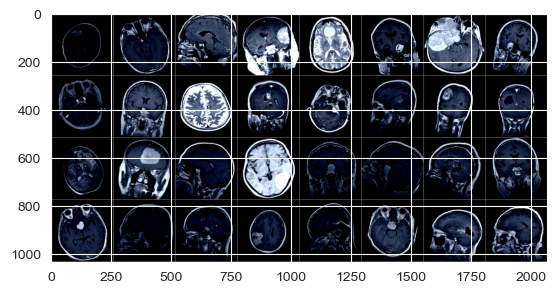

In [17]:
from torchvision.utils import make_grid

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print(images.dtype)  # Check the shape of the images tensor
print(images.dtype)  # Check the shape of the labels tensor

grid_images = make_grid(images)

imshow(grid_images)


https://arxiv.org/pdf/1801.04381 - MobileNetV2 paper

Write example images to tensorboard

In [18]:
writer.add_image('example_images with data augmentation', grid_images)
writer.close()

How the residual block works:
1. Input image goes through an expansion layer (1x1 conv) to increase the number of channels by a factor of expansion_rate (default 6) - expansion_bottleneck - this also acts as a pointwise convolution
2. The expanded image goes through a depthwise separable convolution layer (3x3 conv for each channel) - depthwise_separable_conv
3. The output of the depthwise separable conv goes through a projection layer (1x1 conv) to reduce the number of channels back to out_channels to save computation - linear_bottleneck
4. If the input and output shapes match (same number of channels and stride is 1), a residual connection is added from the input to the output of the linear bottleneck - residual addition
5. The output of the block is returned
6. Multiple blocks are stacked together to form the full MobileNetV2 architecture in the Model class below

In [19]:
#Build the MobileNetV2 model using depthwise separable convolutions, linear bottlenecks, and inverted residuals
#Input, expansion, depthwise separable conv, projection (linear bottleneck), residual addition

class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, expansion_rate=6):
        super(InvertedResidualBlock, self).__init__()
        self.expansion_bottleneck_layer, expanded_channels = self.expansion_bottleneck(in_channels, expansion_rate) # - Expansion layer (pointwise conv 1x1) - Gives us a count of how many channels we have after the expansion
        self.depthwise_separable_conv_layer = self.depthwise_separable_conv(in_channels=expanded_channels, kernal_size=kernel_size, stride=stride, padding=padding) # - Depthwise separable convolution layer
        self.linear_bottleneck_layer  = self.linear_bottleneck(expanded_channels, out_channels) # - Projection layer (Linear bottleneck)
        self.use_residual = self.input_output_shape_match(in_channels, out_channels, stride) # - Check if input and output shapes match for residual addition (if channels are increased in linear bottleneck or stride > 1, shapes won't match) so we can't do a residual addition

    def expansion_bottleneck(self, in_channels, expansion_rate): # - Expansion layer (pointwise conv 1x1)
        #Expands the number of channels by expansion_rate using a 1x1 conv to allow the depth wise conv to learn more features in higher dimensional space
        expanded_channels = in_channels * expansion_rate
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=expanded_channels, kernel_size=1, stride=1, padding=0), #Pointwise conv to expand channels
            nn.BatchNorm2d(expanded_channels),
            nn.ReLU6(inplace=True)
        ), expanded_channels

    def depthwise_separable_conv(self, in_channels, kernal_size=3, stride=1, padding=1): # - Depthwise separable convolution layer
        #Operates on expanded channels from previous layer - Pointwise conv in expansion_bottleneck

        #Depthwise convolution (3x3 conv for each channel), in_channels = out_channels here because we are doing a conv per channel, groups=in_channels means we are doing a conv per channel
        depth_wise_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernal_size, stride=stride, padding=padding, groups=in_channels)

        return nn.Sequential(
            depth_wise_conv,
            nn.BatchNorm2d(in_channels),
            nn.ReLU6(inplace=True),
        )

    def linear_bottleneck(self, in_channels, out_channels): # - Projection layer
        #This is just a 1x1 conv to reduce the number of channels back to in_channels after the depthwise separable conv - back to low dimensional space to save computation and parameters, linear means negative values are not removed like with ReLU
        projection_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0) #Compress channels to low dimensional space with linear conv
        return nn.Sequential(
            projection_layer,
            nn.BatchNorm2d(out_channels), #Batch norm after conv (so on expanded channels)
            #No relu here because its a linear bottleneck - we want to preserve negative values for better representation
        )

    def input_output_shape_match(self, in_channels, out_channels, stride): # - Check if input and output shapes match for residual addition (if channels are increased in linear bottleneck or stride > 1, shapes won't match) so we can't do a residual addition. If stride == not 1, in_channels != out_channels then spatial dimensions will change so can't do residual addition

    #If output channels and input channels are the same and stride is 1, we can do a residual addition because the input and output feature maps will be the same shape
        return in_channels == out_channels and stride == 1

    def forward(self, x): #Preserve input x for residual addition later so 'out' is the output of the linear bottleneck
        out = self.expansion_bottleneck_layer(x)
        out = self.depthwise_separable_conv_layer(out)
        out = self.linear_bottleneck_layer(out)
        if self.use_residual:
            out = out + x #Residual addition - out is the output of the linear bottleneck, x is the input to the block - only if shapes match is it passed through (shortcut connection) - Preserves information from input (so we don't forget what we already know)
        return out

In [20]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.initial_conv_layer = self.general_conv(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1) #Initial conv layer to create feature maps from input image

        #Total 19 inverted residual blocks as per the paper
        self.layer_block_1 = self._make_layer(in_channels=32, out_channels=16, stride=1, padding=1, expansion_rate=1, num_blocks=1) #First layer block - 1 inverted residual block
        self.layer_block_2 = self._make_layer(in_channels=16, out_channels=24, stride=2, padding=1, expansion_rate=6, num_blocks=2) #Second layer block - 2 inverted residual blocks
        self.layer_block_3 = self._make_layer(in_channels=24, out_channels=32, stride=2, padding=1, expansion_rate=6, num_blocks=3) #Third layer block - 3 inverted residual blocks
        self.layer_block_4 = self._make_layer(in_channels=32, out_channels=64, stride=2, padding=1, expansion_rate=6, num_blocks=4) #Fourth layer block - 4 inverted residual blocks
        self.layer_block_5 = self._make_layer(in_channels=64, out_channels=96, stride=1, padding=1, expansion_rate=6, num_blocks=3) #Fifth layer block - 3 inverted residual blocks - Residual connections used here
        self.layer_block_6 = self._make_layer(in_channels=96, out_channels=160, stride=2, padding=1, expansion_rate=6, num_blocks=3) #Sixth layer block - 3 inverted residual blocks
        self.layer_block_7 = self._make_layer(in_channels=160, out_channels=320, stride=1, padding=1, expansion_rate=6, num_blocks=1) #Seventh layer block - 1 inverted residual block

        self.final_conv_layer = self.general_conv(in_channels=320, out_channels=1280, kernel_size=1, stride=1, padding=0) #Final conv layer before pooling and classification
        self.avgpool_and_flatten = self.flatten_and_pooling(output_dim=1) #Adaptive average pooling to get a fixed size output regardless of input image size, then flatten to 1D tensor
        self.classifier = nn.Linear(1280, num_classes) #Final classifier layer

    def flatten_and_pooling(self, output_dim=1):
        return nn.Sequential(
            nn.AdaptiveAvgPool2d(output_dim), #Adaptive average pooling, this will average the channels to a fixed size output_dim x output_dim (1x1 here)
            nn.Flatten(), #Flatten the output to a 1D tensor
        )

    def general_conv(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True) #Relu6 is used in MobileNetV2 - Activations cant above 6 (helps with quantization later on for mobile devices)
        )

    def _make_layer(self, in_channels, out_channels,stride, padding, expansion_rate, num_blocks):
        layers = []
        for i in range(0, num_blocks):
            if i != 0: #First block does the downsampling if stride > 1, subsequent blocks have stride 1 - as per the paper
                in_channels = out_channels #Because the first block will change the number of channels to out_channels, subsequent blocks will have in_channels = out_channels
                stride = 1 #Subsequent blocks will have stride 1, only the first block in the layer can have a stride > 1 to downsample

                #Doing both of these things means the shape will match so the residual addition to be used in subsequent blocks
            layers.append(InvertedResidualBlock(in_channels=in_channels, out_channels=out_channels, stride=stride, padding=padding, expansion_rate=expansion_rate)) #Only the first block in the layer can have a stride > 1 to downsample, subsequent blocks have stride 1

        return nn.Sequential(*layers) #Unpack the layers list into the sequential module

    def forward(self, x):
        x = self.initial_conv_layer(x)
        x = self.layer_block_1(x)

        #The issue is that within each layer block, the first block will up the channels to 24, but the next block will expect 16 channels as input because that is what was passed in when creating the layer block
        #So we need to update in_channels to be out_channels after the first block in each
        x = self.layer_block_2(x)
        x = self.layer_block_3(x)
        x = self.layer_block_4(x)
        x = self.layer_block_5(x)
        x = self.layer_block_6(x)
        x = self.layer_block_7(x)

        x = self.final_conv_layer(x)
        x = self.avgpool_and_flatten(x)
        x = self.classifier(x)
        return x
    print('MobileNetV2 Model Created')

MobileNetV2 Model Created


In [21]:
net = Model(num_classes=4) #4 classes in the dataset

In [22]:
print(net)

Model(
  (initial_conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (layer_block_1): Sequential(
    (0): InvertedResidualBlock(
      (expansion_bottleneck_layer): Sequential(
        (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (depthwise_separable_conv_layer): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (linear_bottleneck_layer): Sequential(
        (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, tr

Add Model graph to tensorboard using a sample image batch

In [23]:
writer.add_graph(net, images)
writer.close()

Device configuration

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
net.to(device)
print(f'Using device: {device}')

Using device: mps


Loss function and optimizer

In [25]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00004)

Training each epoch function

In [26]:
def train_epoch(train_loader, epoch):
    net.train()
    running_loss = 0.0
    tensorboard_loss = running_loss

    for batch_idx, data in enumerate(train_loader, 0): #Get images and target values from the dataloader and give an index via enumerate
        images, targets = data #data is a tuple of (images, targets)
        images, targets = images.to(device), targets.to(device) #images and target values in batch to device
        targets = torch.argmax(targets, dim=1) #Convert one-hot encoded targets to class indices for CrossEntropyLoss
        optimizer.zero_grad() #Clear old gradients
        outputs = net(images) #Models prediction for this batch
        loss = criterion(outputs, targets) #Calcuate loss for this batch - CrossEntropyLoss expects class indices as targets and raw logits as model output
        loss.backward() #Do backprop to get gradients
        optimizer.step() #pdate weights via optimizer step

        running_loss += loss.item() #Add the loss for this batch to the running loss
        tensorboard_loss += loss.item() #Add the loss for this batch to the tensorboard loss

        #Tensorboard logging
        if batch_idx % 10 == 9:    # Log every 10 batches (every 320 images if batch size is 32)
            writer.add_scalar('training loss',
                              tensorboard_loss / 10, epoch * len(train_loader) + batch_idx) #Log the running loss to tensorboard

            tensorboard_loss = 0.0 #This is separate to running loss, just for tensorboard logging otherwise the graph in the notebook would be very granular and hard to read
    return running_loss / len(train_loader) #Average loss over the epoch

Training loop

In [ ]:
num_epochs = 10
loss_values = []
val_loss_values = []
for epoch in range(num_epochs):
    train_loss = train_epoch(train_dataloader, epoch) #Train for one epoch
    loss_values.append(train_loss)

    #Validation
    net.eval()
    val_loss = 0.0

    with torch.no_grad(): #No gradients needed for validation
        for batch_idx, data in enumerate(val_loader, 0):
            images, targets = data
            images, targets = images.to(device), targets.to(device)
            outputs = net(images)
            prediction = torch.argmax(outputs, dim=1) #Get the highest value (the prediction) - this is required for our cost function - hopefully this gives the correct datatype
            loss = criterion(prediction, targets)
            val_loss += loss.item()
    val_loss = val_loss / len(val_loader)
    val_loss_values.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Accuracy functions

In [ ]:
#Train set accuracy
net.eval()
from torcheval.metrics import MulticlassAccuracy
metric = MulticlassAccuracy()
with torch.no_grad(): # No need to compute gradients during evaluation because we are not training
    for data in train_dataloader: #get batches from train loader
        images, labels = data # Get a batch of data broken into images and labels
        images, labels = images.to(device), torch.argmax(labels, dim=1).to(device) # Convert one-hot encoded labels to class indices
        outputs = net(images) # Forward pass (forward propagation)
        prediction = torch.argmax(outputs, dim=1)
        metric.update(prediction, labels) #add batch predictions and labels to metric

accuracy = metric.compute()
print(f"train set accuracy: {accuracy:.4f}")


In [ ]:
#test set accuracy
net.eval()
metric = MulticlassAccuracy()
predictions = []
labels_list = []
with torch.no_grad(): # No need to compute gradients during evaluation because we are not training
    for data in test_loader: #get batches from test loader
        images, labels = data # Get a batch of data broken into images and labels
        images, labels = images.to(device), torch.argmax(labels, dim=1).to(device) # Convert one-hot encoded labels to class indices
        outputs = net(images) # Forward pass
        prediction = torch.argmax(outputs, dim=1)
        predictions.append(prediction)
        labels_list.append(labels)
        metric.update(prediction, labels) #add batch predictions and labels to metric

accuracy = metric.compute()
print(f"test set accuracy: {accuracy:.4f}")

Preparing data for confusion matrix by concatenating all batch predictions and labels into single tensors

In [ ]:
all_predictions = torch.cat(predictions, dim=0) # Concatenate all batch predictions into a single tensor
all_labels = torch.cat(labels_list, dim=0) # Concatenate all batch labels into a single tensor
all_predictions_cpu_tensor = all_predictions.cpu().numpy() # Move tensor to CPU and convert to NumPy array
all_labels_cpu_tensor = all_labels.cpu().numpy() # Move tensor to CPU and convert to NumPy array

In [ ]:
display_labels = test_dataframe.columns[1:]
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(all_labels_cpu_tensor, all_predictions_cpu_tensor, labels=np.arange(len(display_labels)))

print(cm.shape)

matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

_, ax = plt.subplots(figsize=(10, 10))  # Create a figure and axis for the confusion matrix plot (much larger than default
matrix.plot(cmap='Blues', values_format='d', ax=ax, xticks_rotation=90)  # Plot the confusion matrix with blue color map and integer format